In [1]:
import numpy as np
import pandas
import time
import pickle
import os
import gzip
import argparse
import random
import matplotlib.pyplot as plt

In [2]:
"""
data process block
"""

def z_score_normalize(X, u = None, sd = None):
    """
    Performs z-score normalization on X. 

    f(x) = (x - μ) / σ
        where 
            μ = mean of x
            σ = standard deviation of x

    Parameters
    ----------
    X : np.array
        The data to min-max normalize

    Returns
    -------
        Tuple:
            Transformed dataset with mean 0 and stdev 1
            Computed statistics (mean and stdev) for the dataset to undo z-scoring.
    """
    if not u:
        u = np.mean(X)
    if not sd:
        sd = np.std(X)
    return ((X - u) / sd, u, sd)


def min_max_normalize(X, _min = None, _max = None):
    """
    Performs min-max normalization on X. 

    f(x) = (x - min(x)) / (max(x) - min(x))

    Parameters
    ----------
    X : np.array
        The data to min-max normalize

    Returns
    -------
        Tuple:
            Transformed dataset with all values in [0,1]
            Computed statistics (min and max) for the dataset to undo min-max normalization.
    """
    if not _min:
        _min = np.min(X)
    if not _max:
        _max = np.max(X)
    return ((X - _min) / (_max - _min), _min, _max)


def onehot_encode(y):
    """
    Performs one-hot encoding on y.

    Ideas:
        NumPy's `eye` function

    Parameters
    ----------
    y : np.array
        1d array (length n) of targets (k)

    Returns
    -------
        2d array (shape n*k) with each row corresponding to a one-hot encoded version of the original value.
    """
    k = np.max(y) + 1
    y_encode = np.eye(k)[y] 
    return np.array(y_encode)


def onehot_decode(y):
    """
    Performs one-hot decoding on y.

    Ideas:
        NumPy's `argmax` function 

    Parameters
    ----------
    y : np.array
        2d array (shape n*k) with each row corresponding to a one-hot encoded version of the original value.

    Returns
    -------
        1d array (length n) of targets (k)
    """

    y_decode = np.argmax(y, axis=1)
    return np.array(y_decode)

def shuffle(dataset):
    """
    Shuffle dataset.

    Make sure that corresponding images and labels are kept together. 
    Ideas: 
        NumPy array indexing 
            https://numpy.org/doc/stable/user/basics.indexing.html#advanced-indexing

    Parameters
    ----------
    dataset
        Tuple containing
            Images (X)
            Labels (y)

    Returns
    -------
        Tuple containing
            Images (X)
            Labels (y)
    """
    X, y = dataset
    n = len(X)
    indexes = list(range(n))
    random.shuffle(indexes)
    return (X[indexes], y[indexes])

def append_bias(X):
    n, k = X.shape
    return np.hstack((np.ones((n,1)),X))

def generate_minibatches(dataset, batch_size=64):
    X, y = dataset
    l_idx, r_idx = 0, batch_size
    while r_idx < len(X):
        yield X[l_idx:r_idx], y[l_idx:r_idx]
        l_idx, r_idx = r_idx, r_idx + batch_size

    yield X[l_idx:], y[l_idx:]
    
def generate_k_fold_set(dataset, k = 10): 
    # Be sure to modify to include train/val/test
    X, y = dataset
    n = len(X)
    order = np.random.permutation(n)
    
    fold_width = n // k

    l_idx_val, r_idx_val = 0, fold_width
    l_idx_test, r_idx_test = fold_width, fold_width + fold_width

    for i in range(k):
        validation = (X[order[l_idx_val:r_idx_val]], y[order[l_idx_val:r_idx_val]])
        test = (X[order[l_idx_test:r_idx_test]], y[order[l_idx_test: r_idx_test]])
        min_l = min(l_idx_val, l_idx_test)
        max_l = max(l_idx_val, l_idx_test)
        min_r = min(r_idx_val, r_idx_test)
        max_r = max(r_idx_val, r_idx_test)
        train = (np.concatenate([X[order[:min_l]], X[order[min_r:max_l]], X[order[max_r:]]]), np.concatenate([y[order[:min_l]], y[order[min_r:max_l]], y[order[max_r:]]]))
        yield train, validation, test
        l_idx_val, r_idx_val = r_idx_val, r_idx_val + fold_width
        if r_idx_val > n:
            l_idx_val = 0
            r_idx_val = fold_width
        l_idx_test, r_idx_test = r_idx_test, r_idx_test + fold_width
        if r_idx_test > n:
            l_idx_test = 0
            r_idx_test = fold_width


In [3]:
class PCA:
    """
    This class handles all things related to PCA for PA1.

    You can add any new parameters you need to any functions. This is an 
    outline to help you get started.

    You should run PCA on both the training and validation / testing datasets 
    using the same object.

    For the visualization of the principal components, use the internal 
    parameters that are set in `fit`.
    """
    def __init__(self, num_components):
        """
        Setup the PCA object. 

        Parameters
        ----------
        num_components : int
            The number of principal components to reduce to.
        """
        self.num_components = num_components
        self.A = None
        self.mean = None

    def fit(self, X):
        """
        Set the internal parameters of the PCA object to the data.

        Parameters
        ----------
        X : np.array
            Training data to fit internal parameters.
        """
        
        self.mean = np.mean(X, axis=0)
        X = X.copy()
        X -= self.mean
        U, S, Vt = np.linalg.svd(X, full_matrices=False)
        max_abs_cols = np.argmax(np.abs(U), axis=0)
        signs = np.sign(U[max_abs_cols, range(U.shape[1])])
        U *= signs
        Vt *= signs[:, np.newaxis]
        self.A = Vt[:self.num_components, :]
        

    def transform(self, X):
        """
        Use the internal parameters set with `fit` to transform data.

        Make sure you are using internal parameters computed during `fit` 
        and not recomputing parameters every time!

        Parameters
        ----------
        X : np.array - size n*k
            Data to perform dimensionality reduction on

        Returns
        -------
            Transformed dataset with lower dimensionality
        """
        X = X.copy()
        X -= self.mean
        return np.dot(X, self.A.T)


    def fit_transform(self, X):
        self.fit(X)
        return self.transform(X)


In [4]:
"""
load data
"""

def load_traffic(kind='aligned', subclass=None):
    
    t_file = "./data/train" + "_wb_" + kind +".p"

    """Load traffic data from `path`"""
    with open(t_file, mode='rb') as f:
        train = pickle.load(f)

    images, labels = train['features'], train['labels']
    images = images.reshape((images.shape[0], -1))

    return images, labels
images_aligned, labels_aligned = load_traffic(kind='aligned')
images_unaligned, labels_unaligned = load_traffic(kind='unaligned')

In [5]:
"""
Activation Function and Loss Function
"""

def sigmoid(a):
    """
    Compute the sigmoid function.

    f(x) = 1 / (1 + e ^ (-x))

    Parameters
    ----------
    a
        The internal value while a pattern goes through the network
    Returns
    -------
    float
       Value after applying sigmoid (z from the slides).
    """
    threshold = 500 # in case exp(a) is too large to be nan
    a[a>threshold]=threshold
    a[a<-threshold]=-threshold
    return 1 / (1 + np.exp(-a))

def binary_cross_entropy(y, t):
    """
    Compute binary cross entropy.

    L(x) = t*ln(y) + (1-t)*ln(1-y)

    Parameters
    ----------
    y
        The network's predictions
    t
        The corresponding targets
    Returns
    -------
    float 
        binary cross entropy loss value according to above definition
    """
    return -(t*np.log(y + 1e-12) + (1-t)*np.log(1-y + 1e-12))

def softmax(a):
    """
    Compute the softmax function.

    f(x) = (e^x) / Σ (e^x)

    Parameters
    ----------
    a
        The internal value while a pattern goes through the network
    Returns
    -------
    float
       Value after applying softmax (z from the slides).
    """
    threshold = 500 # in case exp(a) is too large to be nan
    a[a>threshold]=threshold
    a[a<-threshold]=-threshold
    return np.exp(a) / np.sum(np.exp(a), axis=1).reshape(-1, 1)

def multiclass_cross_entropy(y, t):
    """
    Compute multiclass cross entropy.

    L(x) = - Σ (t*ln(y))

    Parameters
    ----------
    y
        The network's predictions
    t
        The corresponding targets
    Returns
    -------
    float 
        multiclass cross entropy loss value according to above definition
    """
    return -np.mean(np.sum(np.log(y + 1e-12)*t, axis = 1))

In [6]:
class Network:
    def __init__(self, hyperparameters, activation, loss):
        """
        Perform required setup for the network.

        Initialize the weight matrix, set the activation function, save hyperparameters.

        You may want to create arrays to save the loss values during training.

        Parameters
        ----------
        hyperparameters
            A Namespace object from `argparse` containing the hyperparameters
        activation
            The non-linear activation function to use for the network
        loss
            The loss function to use while training and testing
        """
        self.hyperparameters = hyperparameters
        self.activation = activation
        self.loss = loss

        self.weights = np.ones((hyperparameters['in_dim'] + 1, hyperparameters['out_dim']))

    def forward(self, X):
        """
        Apply the model to the given patterns

        Use `self.weights` and `self.activation` to compute the network's output

        f(x) = σ(w*x)
            where
                σ = non-linear activation function
                w = weight matrix

        Make sure you are using matrix multiplication when you vectorize your code!

        Parameters
        ----------
        X
            Patterns to create outputs for
        """
        return self.activation(np.matmul(X, self.weights))

    def __call__(self, X):
        return self.forward(X)

    def train(self, minibatch):
        """
        Train the network on the given minibatch

        Use `self.weights` and `self.activation` to compute the network's output
        Use `self.loss` and the gradient defined in the slides to update the network.

        Parameters
        ----------
        minibatch
            The minibatch to iterate over

        Returns
        -------
        Tuple
            average loss over the minibatch
            accuracy over the minibatch
        """
        X, y = minibatch
        output = self.forward(X)
        
        batch_loss = np.mean(self.loss(output, y))
        accuracy = 0.0
        if y.shape[1] == 1:
            pred = output >= 0.5
            true = y
            accuracy = np.mean(pred == true)
        else:
            pred = np.argmax(output, axis=1)
            true = np.argmax(y, axis = 1)
            accuracy = np.mean(pred==true)

        self.weights -=  self.hyperparameters['learning_rate'] * np.matmul(X.T, (output - y))
        return (batch_loss, accuracy)
        

    def test(self, minibatch):
        """
        Test the network on the given minibatch

        Use `self.weights` and `self.activation` to compute the network's output
        Use `self.loss` to compute the loss.
        Do NOT update the weights in this method!

        Parameters
        ----------
        minibatch
            The minibatch to iterate over
        """
        X, y = minibatch
        
        output = self.forward(X)
        
        batch_loss = np.mean(self.loss(output, y))
        accuracy = 0.0
        pred = None
        if y.shape[1] == 1:
            pred = output >= 0.5
            true = y
            accuracy = np.mean(pred == true)
        else:
            pred = np.argmax(output, axis=1)
            true = np.argmax(y, axis = 1)
            accuracy = np.mean(pred==true)
        return (batch_loss, accuracy, pred)

In [7]:
# Using PCA and Normalization to process X
def process_X_based_train(train_X, valid_X, test_X, pca=None):
    
    if pca:
        pca.fit(train_X)
        train_X = pca.transform(train_X)
        valid_X = pca.transform(valid_X)
        test_X = pca.transform(test_X)
   
    train_X, mu, sd = z_score_normalize(train_X)
    valid_X = (valid_X - mu) / sd
    test_X = (test_X - mu) / sd
    
    train_X = append_bias(train_X)
    valid_X = append_bias(valid_X)
    test_X = append_bias(test_X)
    
    return train_X, valid_X, test_X
    

## Problem 5 
### (b) Evaluate the model on Speed limit 100km/h (class 7) vs Speed limit 120km/h (class 8) using the unaligned dataset.

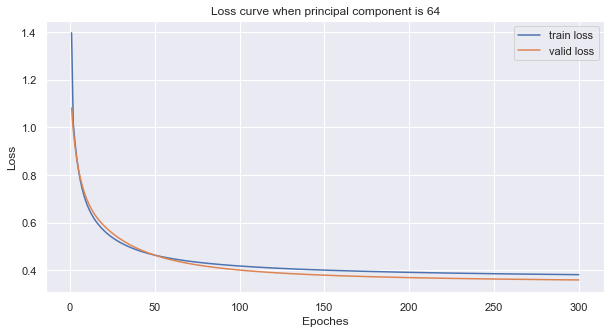

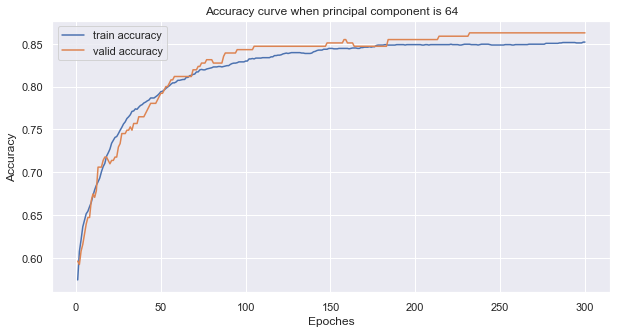

The final result on test data is 0.8627450980392157


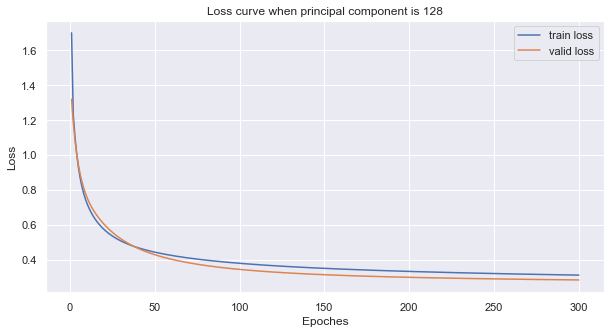

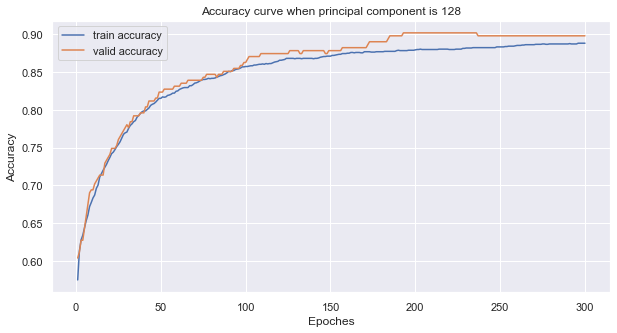

The final result on test data is 0.8901960784313725


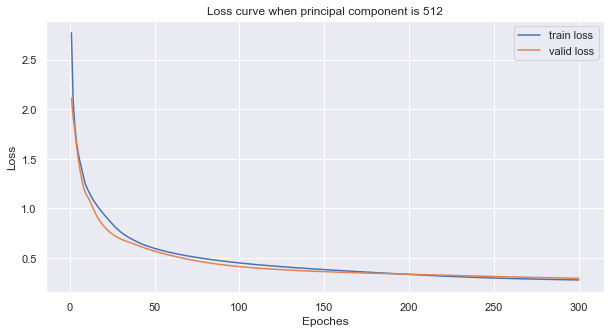

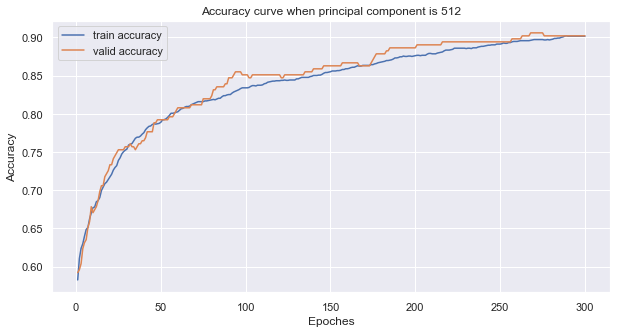

The final result on test data is 0.8549019607843137


In [27]:
"""data process"""
X = images_unaligned[(labels_unaligned == 8) + (labels_unaligned == 7) > 0]
y = labels_unaligned[(labels_unaligned == 8) + (labels_unaligned == 7) > 0].reshape(-1, 1)
y[y==7] = 0
y[y==8] = 1
n = X.shape[0]
X = X.astype(np.float64)
X, y = shuffle((X,y))
train_X_data, train_y = X[:int(n*0.8)], y[:int(n*0.8)]
valid_X_data, valid_y = X[int(n*0.8):int(n*0.9)], y[int(n*0.8):int(n*0.9)]
test_X_data, test_y = X[int(n*0.9):], y[int(n*0.9):]

"""model define"""
hyperparameters = {}
hyperparameters['in_dim'] = 1024
hyperparameters['out_dim'] = 1
hyperparameters['learning_rate'] = 0.001
hyperparameters['k_folds'] = 10
hyperparameters['batch_size']= 128
hyperparameters['epoch'] = 300

for k in [64, 128, 512]:
    hyperparameters['in_dim'] = k
    pca = PCA(hyperparameters['in_dim'])
    model = Network(hyperparameters, sigmoid, binary_cross_entropy)
    
    train_X, valid_X, test_X = process_X_based_train(train_X_data, valid_X_data, test_X_data, pca)
    
    train_loss_list, valid_loss_list, test_loss_list = [], [], []
    train_acc_list, valid_acc_list, test_acc_list = [], [], []
    
    for t in range(hyperparameters['epoch']):
        
        total_loss, total_acc = [], []
        for batch_X, batch_y in generate_minibatches((train_X, train_y), batch_size=hyperparameters['batch_size']):
            batch_loss, batch_acc = model.train((batch_X, batch_y))
            total_loss.append(batch_loss)
            total_acc.append(batch_acc)
        valid_loss, valid_acc, _ = model.test((valid_X, valid_y))
        test_loss, test_acc, _ = model.test((test_X, test_y))
        
        train_loss_list.append(np.mean(total_loss))
        valid_loss_list.append(np.mean(valid_loss))
        test_loss_list.append(np.mean(test_loss))
        
        train_acc_list.append(np.mean(total_acc))
        valid_acc_list.append(valid_acc)
        test_acc_list.append(test_acc)
        
    x = list(range(1, hyperparameters['epoch'] + 1))
    plt.figure(figsize=(10, 5))
    plt.plot(x, train_loss_list, label="train loss")
    plt.plot(x, valid_loss_list, label="valid loss")
    #plt.plot(x, test_loss_list, label="test loss")
    plt.title("Loss curve when principal component is {}".format(k))
    plt.xlabel("Epoches")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()
    
    plt.figure(figsize=(10, 5))
    plt.plot(x, train_acc_list, label="train accuracy")
    plt.plot(x, valid_acc_list, label="valid accuracy")
    #plt.plot(x, test_acc_list, label="test accuracy")
    plt.title("Accuracy curve when principal component is {}".format(k))
    plt.xlabel("Epoches")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.show()
    
    index = np.argmax(valid_acc_list)
    
    print("The final result on test data is {}".format(test_acc_list[ index]))

    

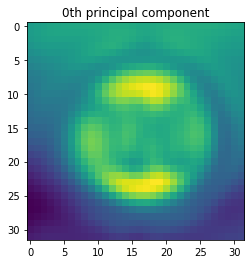

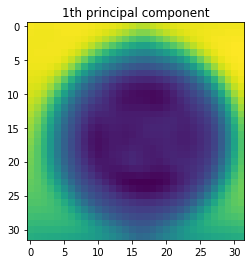

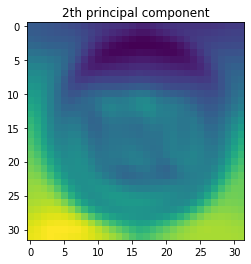

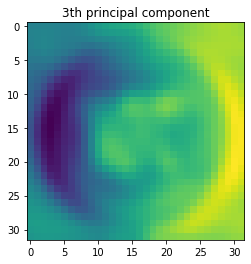

In [14]:
# Plot the top 4 components of PCA
def plot_PCA_Components(X):
    new_X = X - np.mean(X, axis=0)
    XTX = new_X.dot(new_X.T) 
    lam,v= np.linalg.eigh(XTX)
    new_index = np.argsort(lam)[::-1]
    A = new_X.T.dot(v[:,new_index])
    plt.figure()
    plt.title("0th principal component")
    plt.imshow(A[:,0].reshape(32,32))
    plt.show()
    plt.figure()
    plt.title("1th principal component")
    plt.imshow(A[:, 1].reshape(32,32))
    plt.show()
    plt.figure()
    plt.title("2th principal component")
    plt.imshow(A[:, 2].reshape(32,32))
    plt.show()
    plt.figure()
    plt.title("3th principal component")
    plt.imshow(A[:, 3].reshape(32,32))
    plt.show()
    
plot_PCA_Components(X)

### (c) Evaluate on Speed limit 100km/h (class 7) vs Speed limit 120km/h (class 8) on the aligned dataset. 

In [44]:
# train the model with k fold method and plot the result
def train_and_plot_with_k_fold(hyperparameters, is_binary=True, is_pca=True):
    
    final_train_loss_list, final_valid_loss_list, final_test_loss_list = [], [], []
    final_train_acc_list, final_valid_acc_list, final_test_acc_list = [], [], []

    for train_data, valid_data, test_data in generate_k_fold_set((X, y), k = 10):
        train_X, train_y = train_data
        valid_X, valid_y = valid_data
        test_X, test_y = test_data
        
        model = None
        if is_binary:
            model = Network(hyperparameters, sigmoid, binary_cross_entropy)
        else:
            model = Network(hyperparameters, sigmoid, multiclass_cross_entropy)
        
        pca = None
        if is_pca:
            pca = PCA(hyperparameters['in_dim'])

        train_loss_list, valid_loss_list, test_loss_list = [], [], []
        train_acc_list, valid_acc_list, test_acc_list = [], [], []

        train_X, valid_X, test_X = process_X_based_train(train_X, valid_X, test_X, pca)
        
        for t in range(hyperparameters['epoch']):
            total_loss, total_acc = [], []
            for batch_X, batch_y in generate_minibatches((train_X, train_y), batch_size=hyperparameters['batch_size']):
                
                
                batch_loss, batch_acc = model.train((batch_X, batch_y))
                total_loss.append(batch_loss)
                total_acc.append(batch_acc)
            valid_loss, valid_acc, _= model.test((valid_X, valid_y))
            test_loss, test_acc, _ = model.test((test_X, test_y))

            train_loss_list.append(np.mean(total_loss))
            valid_loss_list.append(np.mean(valid_loss))
            test_loss_list.append(np.mean(test_loss))

            train_acc_list.append(np.mean(total_acc))
            valid_acc_list.append(valid_acc)
            test_acc_list.append(test_acc)

        final_train_loss_list.append(train_loss_list)
        final_valid_loss_list.append(valid_loss_list)
        final_test_loss_list.append(test_loss_list)

        final_train_acc_list.append(train_acc_list)
        final_valid_acc_list.append(valid_acc_list)
        final_test_acc_list.append(test_acc_list)
        

    final_train_loss_list = np.array(final_train_loss_list)
    final_valid_loss_list = np.array(final_valid_loss_list)
    final_test_loss_list = np.array(final_test_loss_list)

    final_train_acc_list = np.array(final_train_acc_list)
    final_valid_acc_list = np.array(final_valid_acc_list)
    final_test_acc_list = np.array(final_test_acc_list)
    index = np.argmax(final_valid_acc_list, axis = 1)
    
    print("The final result on test data is {}({})".format(np.mean(final_test_acc_list[range(10), index]), np.std(final_test_acc_list[range(10), index])))
    return (final_train_loss_list, final_valid_loss_list, final_test_loss_list), (final_train_acc_list,  final_valid_acc_list, final_test_acc_list)
    
def plot_result(loss, accuracy, lr, kc, pca=True):
    final_train_loss_list, final_valid_loss_list, final_test_loss_list = loss
    final_train_acc_list,  final_valid_acc_list, final_test_acc_list = accuracy
    
    x = list(range(1, 301))
    plt.figure(figsize=(10, 5))
    plt.errorbar(x, np.mean(final_train_loss_list, axis=0), np.std(final_train_loss_list, axis=0), errorevery=50, label="train loss")
    plt.errorbar(x, np.mean(final_valid_loss_list, axis=0), np.std(final_valid_loss_list, axis=0), errorevery=50, label="valid loss")
    #plt.errorbar(x, np.mean(final_test_loss_list, axis=0), np.std(final_test_loss_list, axis=0), errorevery=50, label="test loss")
    if pca:
        plt.title("Loss curve when principal component is {}, Learning Rate is {}.".format(kc, lr))
    else:
        plt.title("Loss curve when Learning Rate is {}.".format(lr))
    plt.xlabel("Epoches")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

    plt.figure(figsize=(10, 5))
    plt.errorbar(x, np.mean(final_train_acc_list, axis=0), np.std(final_train_acc_list, axis=0), errorevery=50, label="train accuracy")
    plt.errorbar(x, np.mean(final_valid_acc_list, axis=0), np.std(final_valid_acc_list, axis=0), errorevery=50,  label="valid accuracy")
    #plt.errorbar(x, np.mean(final_test_acc_list, axis=0), np.std(final_test_acc_list, axis=0), errorevery=50,label="test accuracy")
    if pca:
        plt.title("Accuracy curve when principal component is {}, Learning Rate is {}.".format(kc, lr))
    else:
        plt.title("Accuracy curve when Learning Rate is {}.".format(lr))
    plt.xlabel("Epoches")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.show()
    


In [29]:
"""data process"""
X = images_aligned[(labels_aligned == 8) + (labels_aligned == 7) > 0]
y = labels_aligned[(labels_aligned == 8) + (labels_aligned == 7) > 0].reshape(-1, 1)
y[y==7] = 0
y[y==8] = 1
n = X.shape[0]
X = X.astype(np.float64)
X, y = shuffle((X,y))

"""model define"""
hyperparameters = {}
hyperparameters['in_dim'] = 1024
hyperparameters['out_dim'] = 1
hyperparameters['learning_rate'] = 0.005
hyperparameters['k_folds'] = 10
hyperparameters['batch_size']= 128
hyperparameters['epoch'] = 300

The final result on test data is 0.9392156862745098(0.016844495368560412)
The 


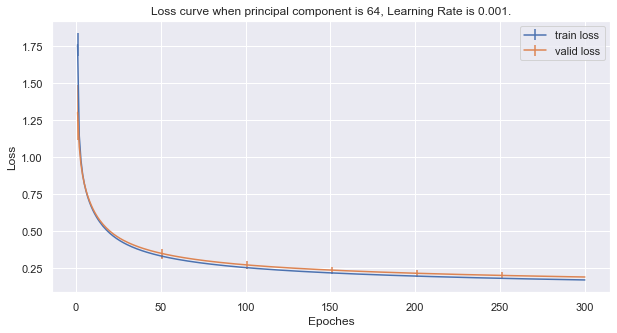

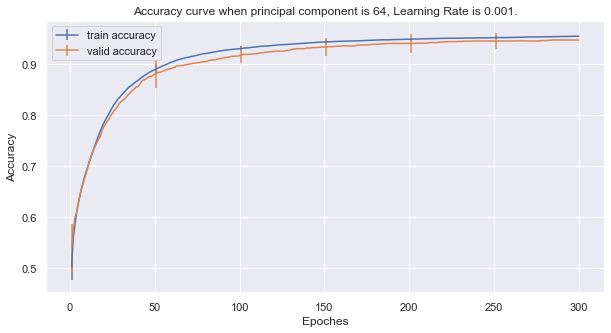

The final result on test data is 0.9552941176470588(0.01314749381509036)
The 


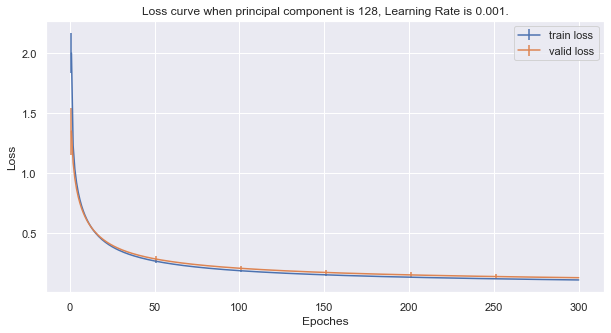

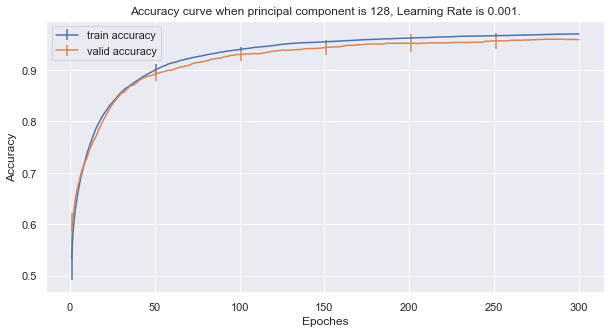

The final result on test data is 0.9650980392156863(0.014509803921568639)
The 


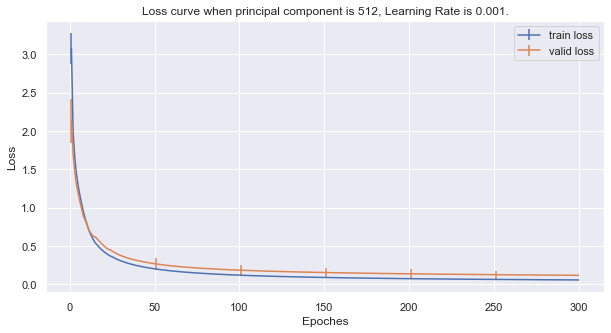

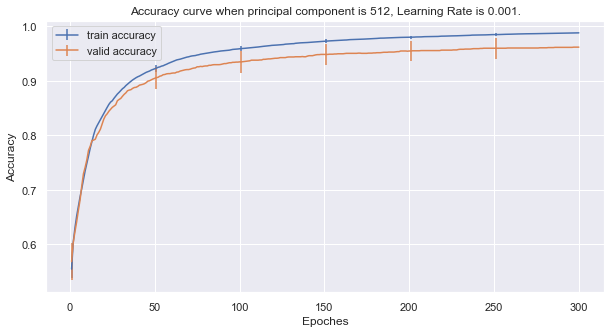

The final result on test data is 0.956078431372549(0.009079087766894308)
The 


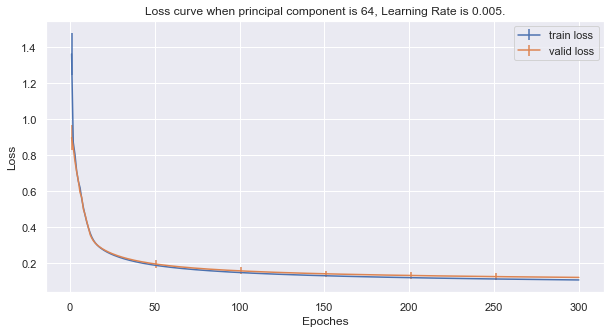

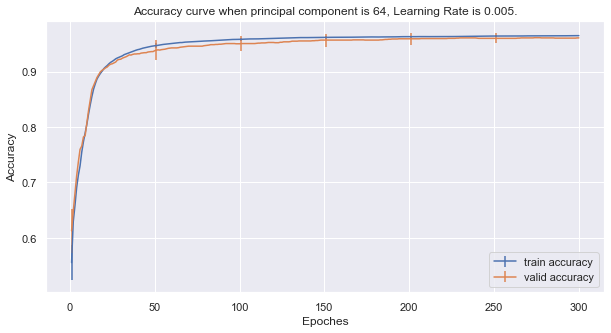

The final result on test data is 0.9713725490196078(0.011639860454632006)
The 


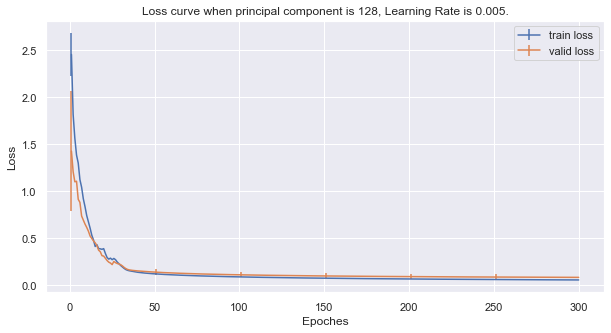

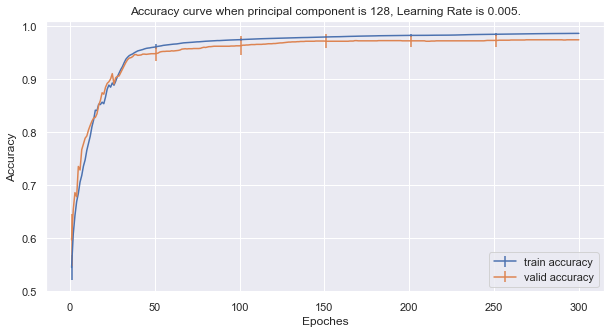

The final result on test data is 0.9780392156862746(0.011257019681888095)
The 


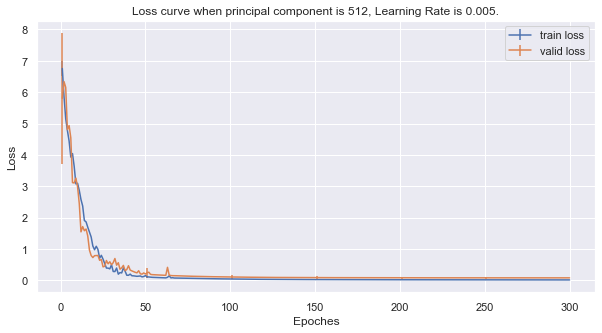

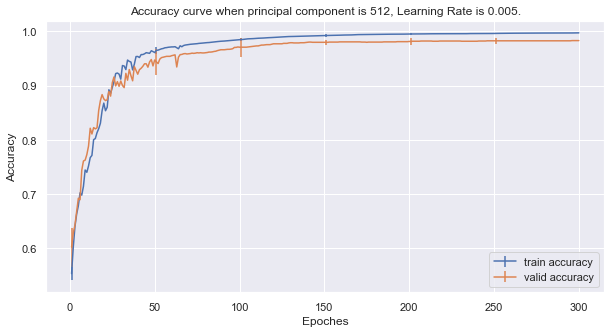

The final result on test data is 0.9584313725490196(0.006608744920138335)
The 


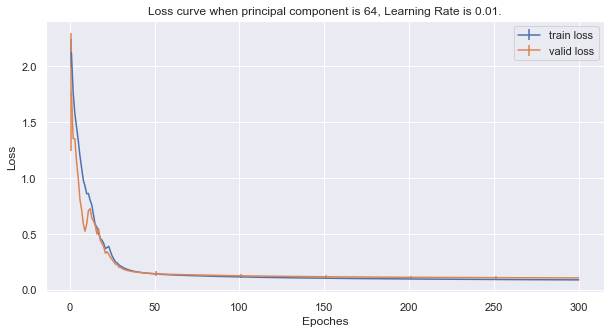

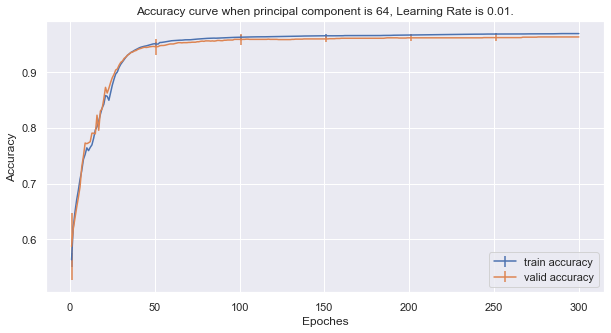

The final result on test data is 0.9635294117647059(0.013590371334245867)
The 


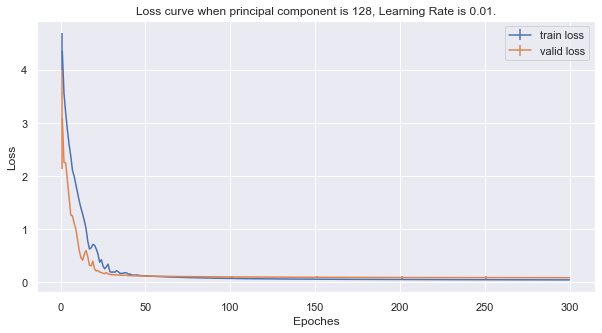

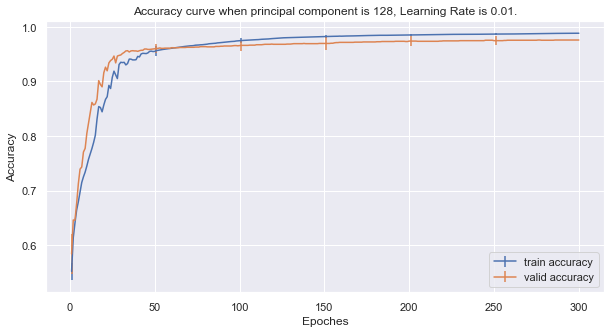

The final result on test data is 0.9764705882352942(0.010952345132367789)
The 


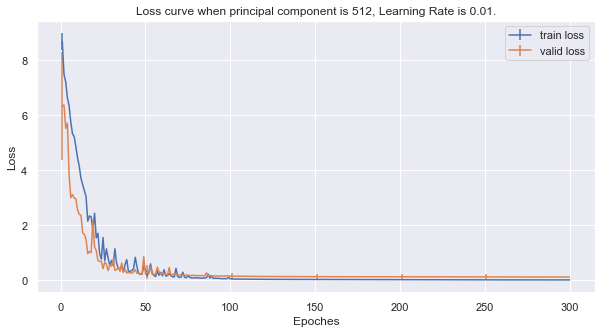

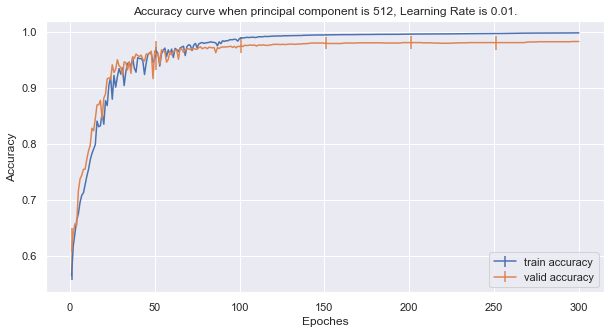

In [30]:
for lr in [0.001, 0.005, 0.01]:
    hyperparameters['learning_rate'] = lr
    for k in [64, 128, 512]:
        hyperparameters['learning_rate'] = lr
        hyperparameters['in_dim'] = k
        pca = PCA(hyperparameters['in_dim'])
        loss, accuracy = train_and_plot_with_k_fold(hyperparameters)
        plot_result(loss, accuracy, lr, k)

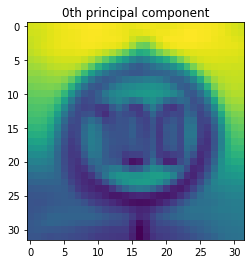

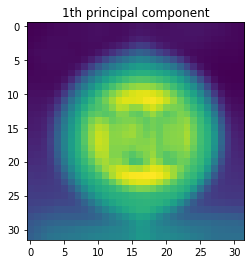

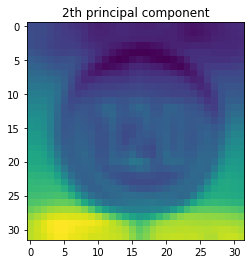

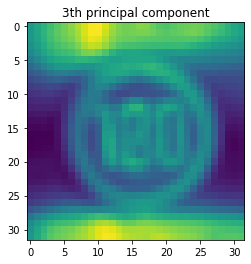

In [18]:
plot_PCA_Components(X)

### (d) Evaluate on Dangerous curve to the left (class 19) vs Dangerous curve to the right (class 20) on the aligned dataset. 

In [31]:
"""data process"""
X = images_aligned[(labels_aligned == 19) + (labels_aligned == 20) > 0]
y = labels_aligned[(labels_aligned == 19) + (labels_aligned == 20) > 0].reshape(-1, 1)
y[y==19] = 0
y[y==20] = 1
n = X.shape[0]
X = X.astype(np.float64)
X, y = shuffle((X, y))

"""model define"""
hyperparameters = {}
hyperparameters['in_dim'] = 1024
hyperparameters['out_dim'] = 1
hyperparameters['learning_rate'] = 0.005
hyperparameters['k_folds'] = 10
hyperparameters['batch_size']= 128
hyperparameters['epoch'] = 300

The final result on test data is 0.9625(0.04732423621500228)
The 


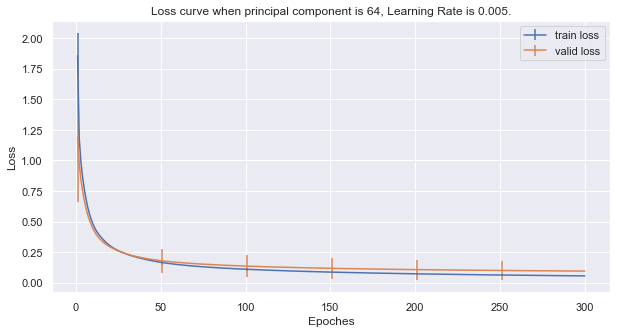

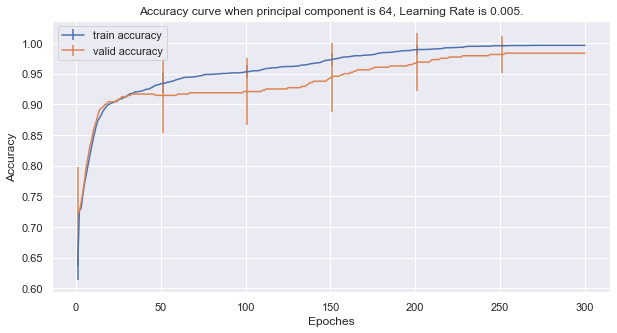

The final result on test data is 0.9666666666666666(0.03510895738823482)
The 


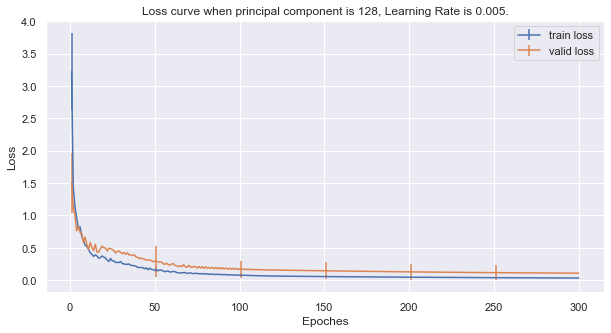

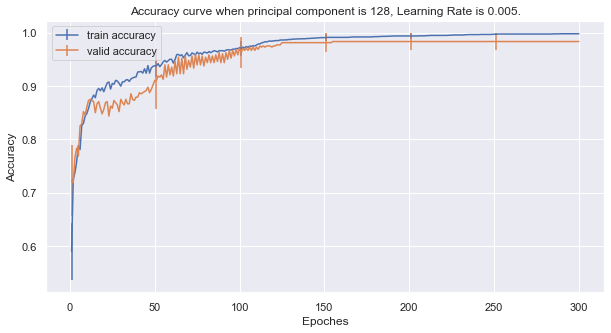

The final result on test data is 0.95625(0.027083333333333334)
The 


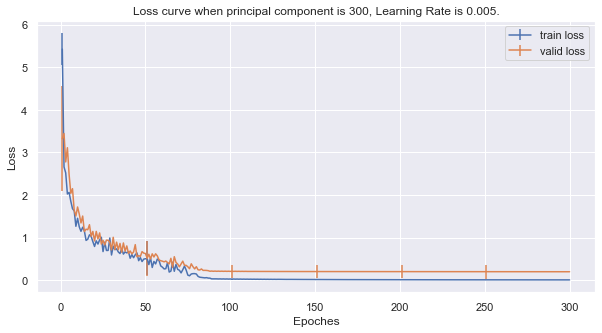

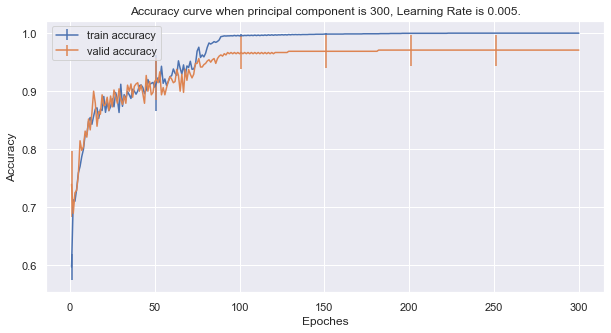

In [32]:
for k in [64, 128,300]:
    hyperparameters['in_dim'] = k
    loss, accuracy = train_and_plot_with_k_fold(hyperparameters)
    plot_result(loss, accuracy, hyperparameters['learning_rate'], hyperparameters['in_dim'])

## 6. Implement Softmax Regression via Gradient Descent. 

### (a) Evaluate your network on all 43 traffic signs (aligned dataset). (15 points)

####  i. Plot the loss on the training set as well as the loss on the holdout set vs. number of epochs of gradient descent. In a case like this, we naturally find the maximum output, say yin for input pattern xn and choose the ith category as the system’s choice. Again, plot the average over 10 runs. We achieved a test accuracy of 90%.

The final result on test data is 0.8985915492957746(0.004677047250621791)
The 


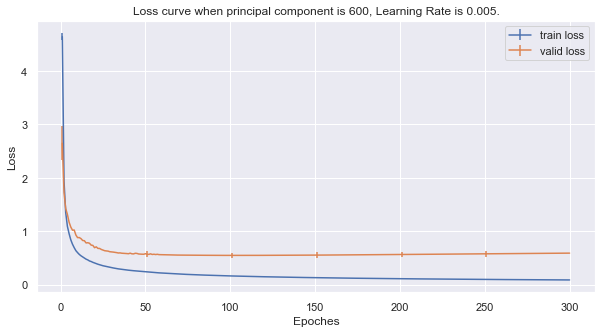

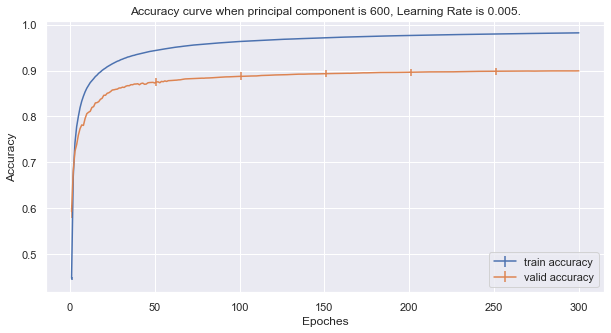

In [34]:
"""data process"""
X = images_aligned.copy()
y = labels_aligned.copy()
X = X + 0.0
n = X.shape[0]
X, y = shuffle((X,y))
y = onehot_encode(y)

"""model define"""
hyperparameters = {}
hyperparameters['in_dim'] = 600
hyperparameters['out_dim'] = 43
hyperparameters['learning_rate'] = 0.005
hyperparameters['k_folds'] = 10
hyperparameters['batch_size']= 64
hyperparameters['epoch'] = 300

loss_6a, accuracy_6a = train_and_plot_with_k_fold(hyperparameters, is_binary=False)
plot_result(loss_6a, accuracy_6a, hyperparameters['learning_rate'], hyperparameters['in_dim'])

#### ii. Now, repeat part i, without PCA on the aligned dataset. Next, repeat part i, with PCA on the unaligned dataset. Compare these results against part i and comment on the importance of data preprocessing (i.e., PCA and aligning).

The final result on test data is 0.8451566542109802(0.0076741885112466685)


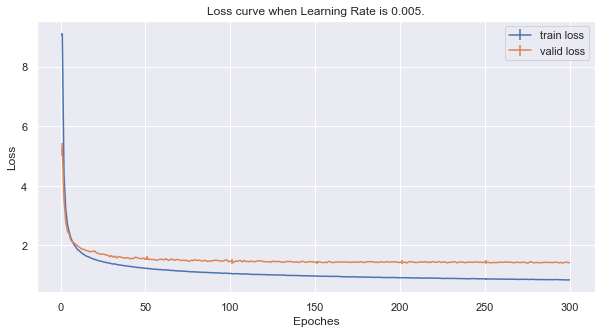

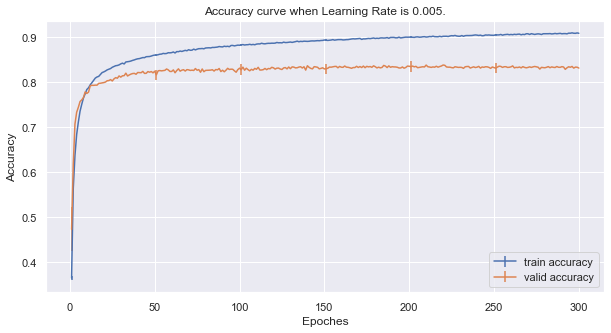

In [45]:
X = images_aligned.copy()
y = labels_aligned.copy()
X = X + 0.0
n = X.shape[0]
X, y = shuffle((X,y))
y = onehot_encode(y)

"""model define"""
hyperparameters = {}
hyperparameters['in_dim'] = 1024
hyperparameters['out_dim'] = 43
hyperparameters['learning_rate'] = 0.005
hyperparameters['k_folds'] = 10
hyperparameters['batch_size']= 64
hyperparameters['epoch'] = 300

loss_6b, accuracy_6b = train_and_plot_with_k_fold(hyperparameters, is_binary=False, is_pca=False)
plot_result(loss_6b, accuracy_6b, hyperparameters['learning_rate'], hyperparameters['in_dim'], pca=False)

The final result on test data is 0.6730094854843346(0.01075820556385709)
The 


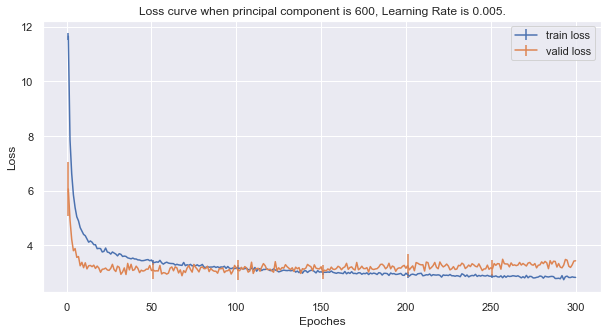

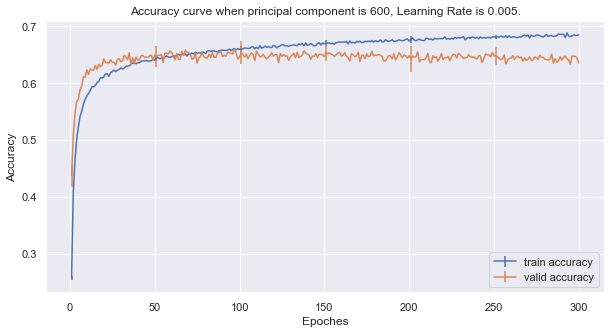

In [35]:
"""data process"""
X = images_unaligned.copy()
y = labels_unaligned.copy()
X = X.astype(np.float64)
n = X.shape[0]
X, y = shuffle((X,y))
y = onehot_encode(y)

"""model define"""
hyperparameters = {}
hyperparameters['in_dim'] = 600
hyperparameters['out_dim'] = 43
hyperparameters['learning_rate'] = 0.005
hyperparameters['k_folds'] = 10
hyperparameters['batch_size']= 128
hyperparameters['epoch'] = 300

loss_6c, accuracy_6c = train_and_plot_with_k_fold(hyperparameters, is_binary=False)
plot_result(loss_6c, accuracy_6c, hyperparameters['learning_rate'], hyperparameters['in_dim'])

#### iii. Create a table that is a 43 × 43 confusion matrix for this data based on the test set results. The class label should be listed along the top and left side of the matrix. The confusion matrix will have 432 entries, Cij, where i is the correct traffic sign and j is the traffic sign chosen by the network, and Cij is the percent time that j was chosen for i. Hence the rows should add to 100%. A perfect system will have 100% down the diagonal and 0’s everywhere else. Your system will most likely not be perfect!

In [23]:
import seaborn as sns

"""data process"""
X = images_aligned.copy()
y = labels_aligned.copy()
X = X + 0.0
n = X.shape[0]
X, y = shuffle((X,y))
y = onehot_encode(y)

hyperparameters = {}
hyperparameters['in_dim'] = 600
hyperparameters['out_dim'] = 43
hyperparameters['learning_rate'] = 0.005
hyperparameters['k_folds'] = 10
hyperparameters['batch_size']= 64
hyperparameters['epoch'] = 300

model = Network(hyperparameters, softmax, multiclass_cross_entropy)
pca = PCA(hyperparameters['in_dim'])
M = None
accuracy = 0
predictions = []
label = []
for train_data, valid_data, test_data in generate_k_fold_set((X, y), k = 10):
    train_X, train_y = train_data
    valid_X, valid_y = valid_data
    test_X, test_y = test_data
    train_X, valid_X, test_X = process_X_based_train(train_X, valid_X, test_X, pca)
    label = list(np.argmax(test_y, axis=1))
    max_acc = 0
    accuracy = 0
    for t in range(hyperparameters['epoch']):
        total_loss, total_acc = [], []
        for batch_X, batch_y in generate_minibatches((train_X, train_y), batch_size=hyperparameters['batch_size']):

            batch_loss, batch_acc = model.train((batch_X, batch_y))
            total_loss.append(batch_loss)
            total_acc.append(batch_acc)
        valid_loss, valid_acc, _ = model.test((valid_X, valid_y))
        if max_acc < valid_acc:
            test_loss, test_acc, pred = model.test((test_X, test_y))
            max_acc = valid_acc
            accuracy = test_acc  
            predictions = pred
    break

The accuracy on test data is 0.9129060074734119.


Text(156.5, 0.5, 'true')

<Figure size 720x720 with 0 Axes>

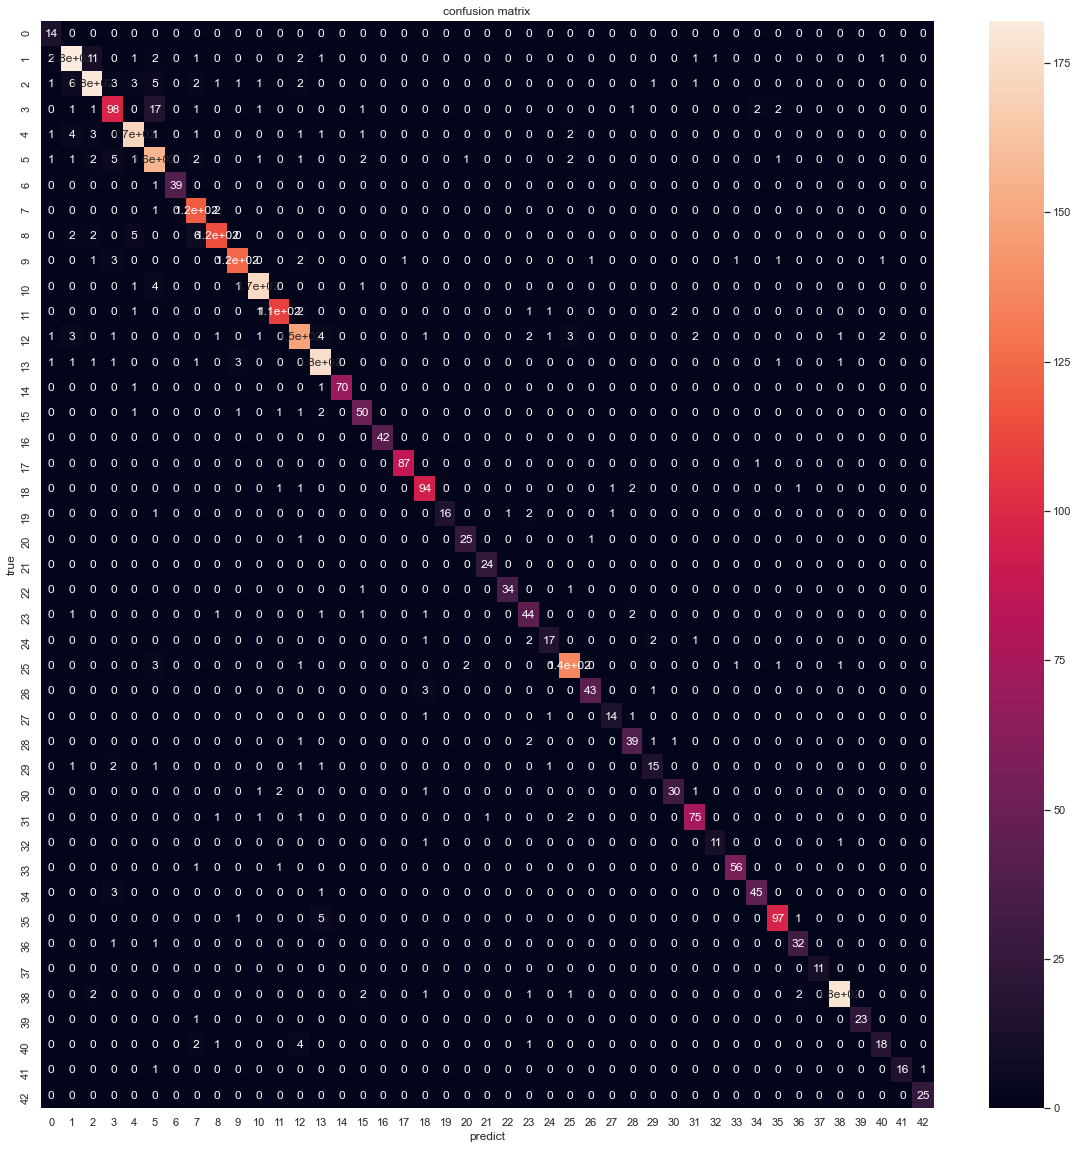

In [24]:
def Confusion(prediction, label):
    M=np.zeros((43,43))
    for p, t in zip(prediction, label):
        M[t][p] += 1
    return M

predictions = list(predictions)

M = Confusion(predictions, label)
M = M.astype(np.int64)
print("The accuracy on test data is {}.".format(accuracy))
sns.set()
plt.figure(figsize=(10,10))
f,ax=plt.subplots(figsize=(20,20))
sns.heatmap(M,annot=True,ax=ax)
ax.set_title('confusion matrix')
ax.set_xlabel('predict')
ax.set_ylabel('true')

In [25]:
print(M)

[[ 14   0   0 ...   0   0   0]
 [  2 182  11 ...   1   0   0]
 [  1   6 180 ...   0   0   0]
 ...
 [  0   0   0 ...  18   0   0]
 [  0   0   0 ...   0  16   1]
 [  0   0   0 ...   0   0  25]]


### (b) Batch versus stochastic gradient descent.(5 points)

In [ ]:
X = images_aligned.copy()
y = labels_aligned.copy()
X = X + 0.0
n = X.shape[0]
X, y = shuffle((X,y))
y = onehot_encode(y)

hyperparameters = {}
hyperparameters['in_dim'] = 600
hyperparameters['out_dim'] = 43
hyperparameters['learning_rate'] = 0.005
hyperparameters['k_folds'] = 10
hyperparameters['batch_size']= 64
hyperparameters['epoch'] = 300
    
pca = PCA(hyperparameters['in_dim'])

total_loss_list_batch = []
total_loss_list_sto = []

for train_data, valid_data, test_data in generate_k_fold_set((X, y), k = 10):
    train_X, train_y = train_data
    valid_X, valid_y = valid_data
    test_X, test_y = test_data
    
    bgd_loss_list, sgd_loss_list = [], []
    
    train_X, valid_X, test_X = process_X_based_train(train_X, valid_X, test_X, pca)

    model = Network(hyperparameters, softmax, multiclass_cross_entropy)
    for t in range(30):
        total_loss = []
        for batch_X, batch_y in generate_minibatches((train_X, train_y), batch_size=hyperparameters['batch_size']):
            batch_loss, batch_acc = model.train((batch_X, batch_y))
            total_loss.append(batch_loss)
        bgd_loss_list.append(np.mean(total_loss))
    total_loss_list_batch.append(bgd_loss_list)

    model = Network(hyperparameters, softmax, multiclass_cross_entropy)
    for t in range(30):
        total_loss = []
        for batch_X, batch_y in generate_minibatches((train_X, train_y), batch_size=hyperparameters['batch_size']):
            batch_loss, batch_acc = model.train((batch_X, batch_y))
            total_loss.append(batch_loss)
        sgd_loss_list.append(np.mean(total_loss))
    total_loss_list_sto.append(sgd_loss_list)

total_loss_list_sto = np.array(total_loss_list_sto)
total_loss_list_batch = np.array(total_loss_list_batch)

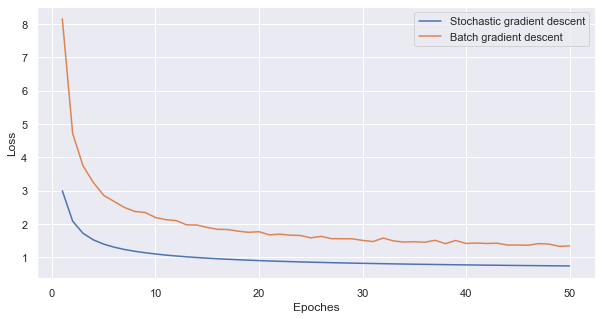

In [123]:
x = range(1, 51)
plt.figure(figsize=(10, 5))
plt.errorbar(x, np.mean(total_loss_list_sto, axis=0), np.std(total_loss_list_sto, axis=0), errorevery=5, label="Stochastic gradient descent")
plt.errorbar(x, np.mean(total_loss_list_batch, axis=0), np.std(total_loss_list_batch, axis=0), errorevery=5, label="Batch gradient descent")
plt.xlabel("Epoches")
plt.ylabel("Loss")
plt.legend()
plt.show()

### (c) Visualize the weights (5 points).

In [ ]:
X = images_aligned.copy()
y = labels_aligned.copy()
X = X + 0.0
n = X.shape[0]
X, y = shuffle((X,y))
y = onehot_encode(y)

hyperparameters = {}
hyperparameters['in_dim'] = 1024
hyperparameters['out_dim'] = 43
hyperparameters['learning_rate'] = 0.005
hyperparameters['k_folds'] = 10
hyperparameters['batch_size']= 128
hyperparameters['epoch'] = 300

model = None
for train_data, valid_data, test_data in generate_k_fold_set((X, y), k = 10):
    train_X, train_y = train_data
    valid_X, valid_y = valid_data
    test_X, test_y = test_data

    pca = None 
    train_X, valid_X, test_X = process_X_based_train(train_X, valid_X, test_X, pca)

    model = Network(hyperparameters, sigmoid, multiclass_cross_entropy)
    for t in range(hyperparameters['epoch']):
        total_loss, total_acc = [], []
        for batch_X, batch_y in generate_minibatches((train_X, train_y), batch_size=hyperparameters['batch_size']):
            batch_loss, batch_acc = model.train((batch_X, batch_y))
            total_loss.append(batch_loss)
            total_acc.append(batch_acc)
            
        valid_loss, valid_acc, _= model.test((valid_X, valid_y))
        test_loss, test_acc, _ = model.test((test_X, test_y))
        print(np.mean(total_acc), valid_acc, test_acc)
    break

Category 0


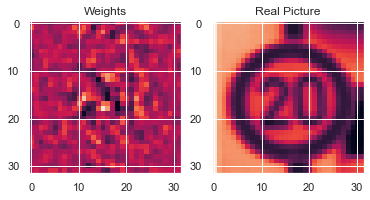

Category 1


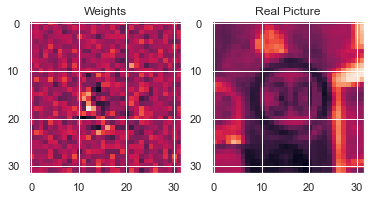

Category 2


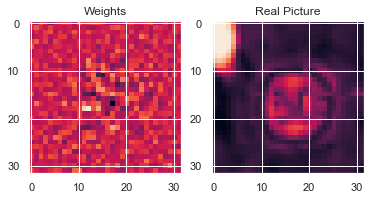

Category 3


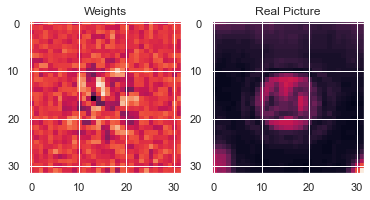

Category 4


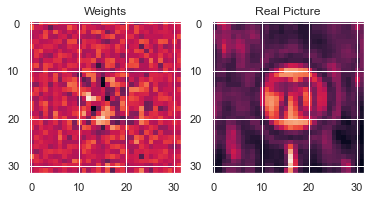

Category 5


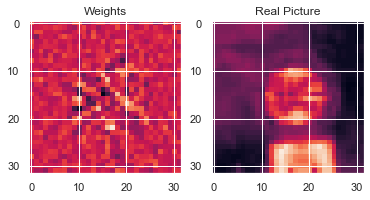

Category 6


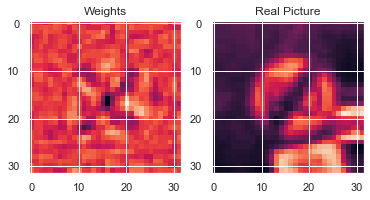

Category 7


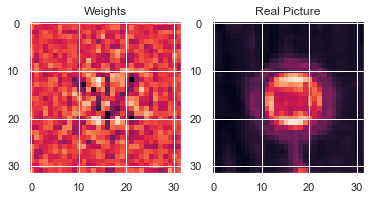

Category 8


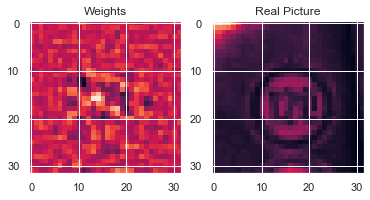

Category 9


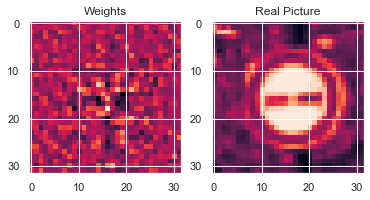

Category 10


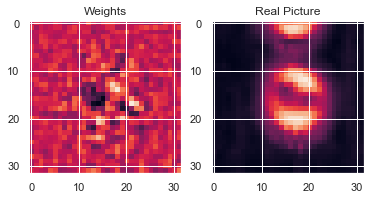

Category 11


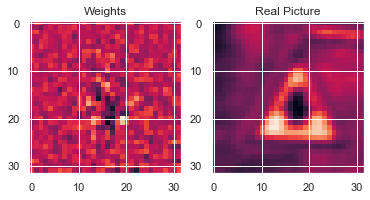

Category 12


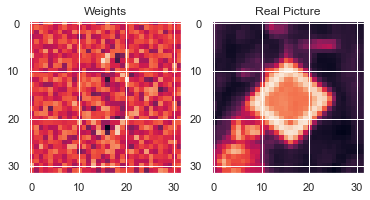

Category 13


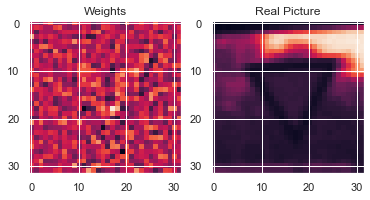

Category 14


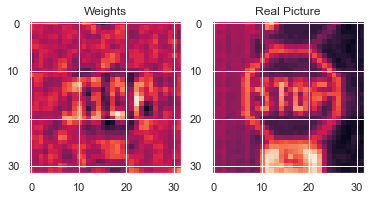

Category 15


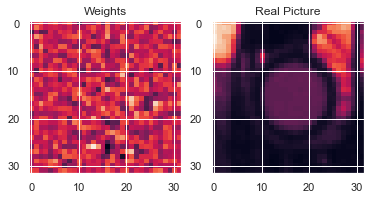

Category 16


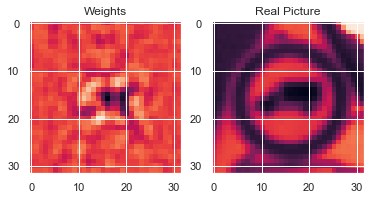

Category 17


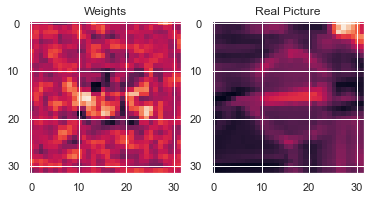

Category 18


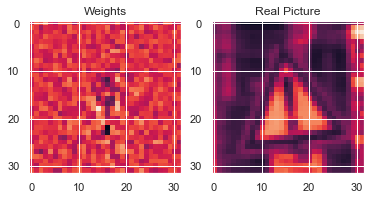

Category 19


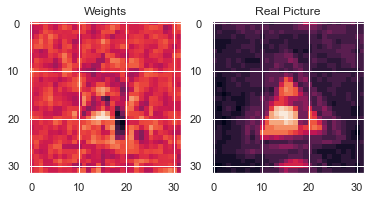

Category 20


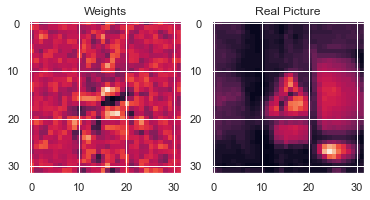

Category 21


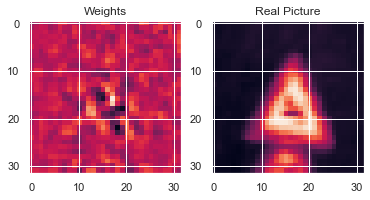

Category 22


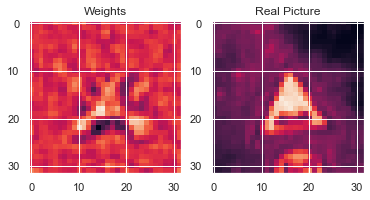

Category 23


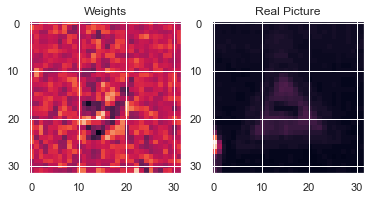

Category 24


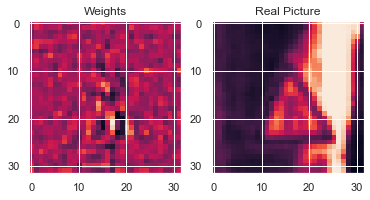

Category 25


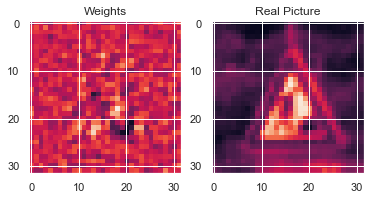

Category 26


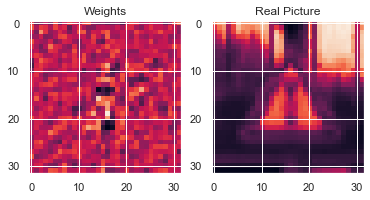

Category 27


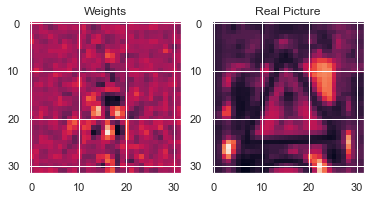

Category 28


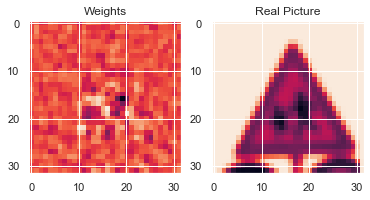

Category 29


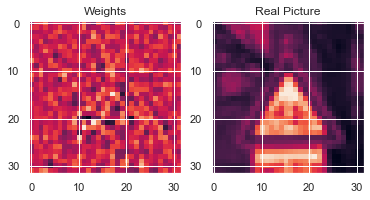

Category 30


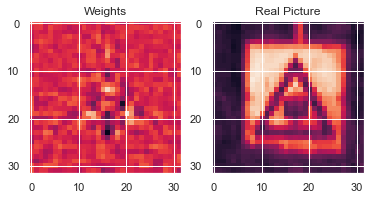

Category 31


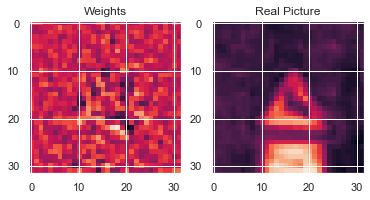

Category 32


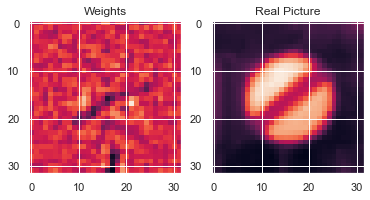

Category 33


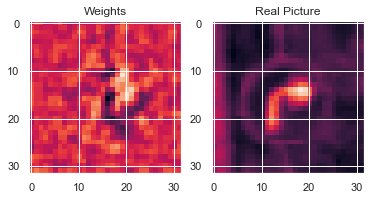

Category 34


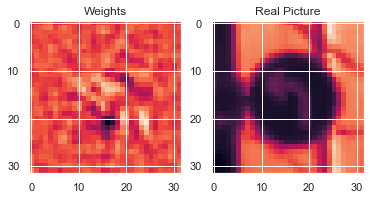

Category 35


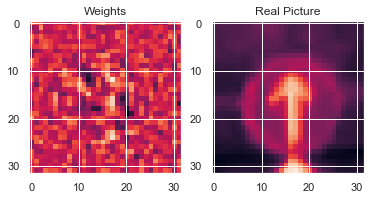

Category 36


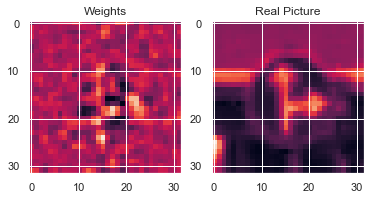

Category 37


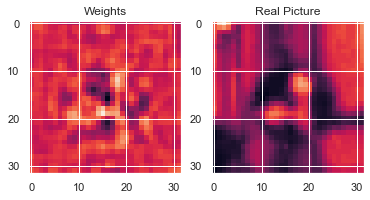

Category 38


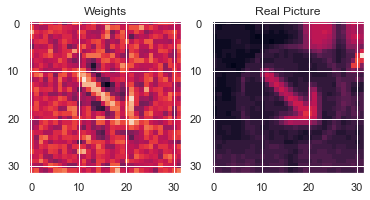

Category 39


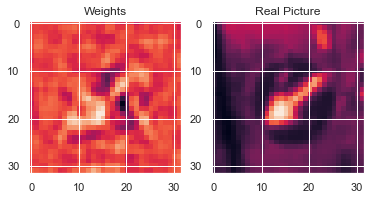

Category 40


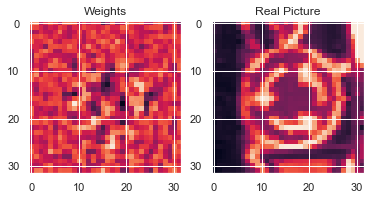

Category 41


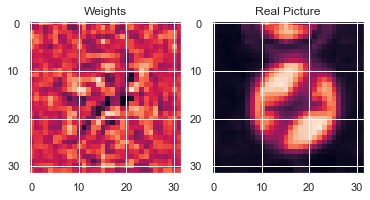

Category 42


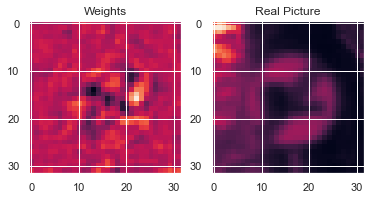

Look Similar, but a little blur. Since the model captures the main feature of this kind of picture.


In [142]:
X = images_aligned.copy()
y = labels_aligned.copy()

weights = model.weights

def tranform_weights(weight):
    max_num = np.max(weight)
    min_num = np.min(weight)
    
    (weight - min_num) * 256 / (max_num - min_num)
    return weight

for i in range(43):
    print("Category", i)
    plt.figure()
    plt.subplot(1, 2, 1)
    weight1 = tranform_weights(weights[1:, i])
    plt.imshow(weight1.reshape(32,32))
    plt.title("Weights")

    plt.subplot(1, 2, 2)
    pic = X[y==i][0].reshape(32,32)
    plt.imshow(pic)
    plt.title("Real Picture")
    plt.show()
    

print("Look Similar, but a little blur. Since the model captures the main feature of this kind of picture.")
